### Assignment 3

#### **Step 6: Risk Management**

Integrate risk management techniques into each strategy to control position sizing, stop-loss levels, and profit-taking mechanisms. This step is crucial to avoid excessive losses and optimize risk-adjusted returns.

**Response 6** All the three techniques are included in the in the following indicators :

- The following strategies are selected :
    + SMA: function name -> calculate_smacrossover_returns
    + EMA: function name -> calculate_emacrossover_returns
    + RSI: function name -> calculate_rsi_returns
    + Donchain Channels: function name -> calculate_dd_returns
    + Bollinger Bands: function name -> calculate_bb_returns

In each indicator calculation, I  have added the following 3 augment :

-> stoploss: This is the percentage that defines the maximum amount of loss the algorithm should consider. For example, if this is set as .05 and total loss on the original investment goes more then 5% then the security will be sold

-> max_profit: This is the percentage that defines the maximum amount of profit the algorithm should consider. For example, if this is set as .5 and total profit on the original investment goes more then 50% then the security will be sold

-> initial_capital: This is the capital size of the security

#### **Step 7: Comparative & Sensitivity Analysis**

Comparative Analysis: Compare the performance of each strategy across different market conditions, including bull, bear, and volatile markets. Analyze how each strategy reacts to changing market dynamics.

Sensitivity Analysis: Conduct sensitivity analysis by varying key parameters of each strategy to evaluate their robustness and stability over time.

In code below, I am running a loop for 3 market conditions:

Bull Market -> The current preiod from 2023 onwards 
Bear Market -> The period around 2020 when there was a big market crash

In addition, sensitivity analysis is performed for the following scenarios relevent for my selected stocks:
- 'Market Crash': -0.5,  # 50% reduction in asset prices
- 'Interest Rate Hike': -0.05,  # 5% decrease in prices due to interest rates


#### **Step 8: Parameter Optmization**
Employ optimization techniques (e.g., grid search, genetic algorithms) to fine-tune the parameters of the selected strategies and improve their overall performance.
Visualizations such as equity curves, drawdown charts, and comparison plots to present the performance of different strategies.


In [ ]:
## Installation of all dependencies
'''
This block only installs the necessary dependencies onto the system. If the libs are already installed, then no need to execute this command.

Known issues 
- The pyfolio lib only works with pandas version < 2.0.0, therefore the highest version below 2.0.0 ( i.e. 1.5.3 ) is used

'''
%pip install pandas==1.5.3
%pip install yfinance==0.2.37
%pip install pyfolio==0.9.2
%pip install empyrical==0.5.5
%pip install pydantic==2.6.3
%pip install matplotlib==3.8.3
%pip install ta==0.11.0


In [383]:
# Import all the libraries required for calculations

import pandas as pd
import pandas as pd
import yfinance as yf
import pyfolio as pf
import datetime as dt
import empyrical as em
import ta
import numpy as np
from pydantic import BaseModel
import warnings
from scipy.stats import norm

import matplotlib.pyplot as plt

import itertools

from datetime import datetime
# Ignore printing all warnings
warnings.filterwarnings('ignore')

In [117]:
# Calculations for all performance metrics, etc annual returns, annual volatilaity, etc

class Settings( BaseModel ):
    period   : str = "1y"
    interval : str = "1d"
    risk_free_rate: float = 0.067188
    days_in_year: int = 252

setting = Settings( )

def get_performance_metrics( return_data ):

    # calcuate the annual ration
    annual_return       = np.mean( return_data ) * setting.days_in_year
    
    # calculate annual volatility ratio
    annual_volatility   = np.std(return_data) * np.sqrt( setting.days_in_year )
    
    # calculate sharpe ratio
    sharpe_ratio        = (annual_return - setting.risk_free_rate) / annual_volatility

    # calculate rolling max window
    rolling_max = return_data.cummax()

    # daily drawdown
    daily_drawdown = return_data / rolling_max - 1.0
    
    max_drawdown = daily_drawdown.cummin().min()

    calmar_ratio = (annual_return - setting.risk_free_rate ) / abs(max_drawdown)

    daily_var = norm.ppf(1-0.05, np.mean(return_data), np.std(return_data))

    negative_std = np.std( return_data [return_data < 0])
    sortino_ratio = (annual_return -setting.risk_free_rate)/(negative_std * np.sqrt(252))

    positive_returns_sum = np.sum( return_data[return_data > 0])
    negative_returns_sum = np.sum( return_data[return_data < 0])
    omega_ratio = positive_returns_sum / abs(negative_returns_sum)

    tail_ratio = abs(np.percentile(return_data.dropna(), 95)) / abs(np.percentile( return_data.dropna(), 5))

    metrics = {
        'annual_return': annual_return,
        'annual_volatility': annual_volatility,
        'sharpe_ratio' : sharpe_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio,
        'daily_value_at_risk': daily_var,
        'sortino_ratio': sortino_ratio,
        'omega_ratio': omega_ratio,
        'tail_ratio': tail_ratio
    }

    return metrics

In [315]:
# Step 6: Risk Management ( SMA CrossOver Strategy ) : 
# Integrate risk management techniques into each strategy to control position sizing, stop-loss levels, and profit-taking mechanisms. 
# This step is crucial to avoid excessive losses and optimize risk-adjusted returns.

def calculate_smacrossover_returns(df, short_window, long_window, stop_loss, max_profit, initial_capital=10000):

    # calculate the long and short moving average of the closing price
    df['short_ma'] = ta.trend.sma_indicator(df['Close'], window=short_window)
    df['long_ma'] = ta.trend.sma_indicator(df['Close'], window=long_window)    

    # Apply stop loss and take profit logic
    position = 0 
    capital = float( initial_capital )
    max_profit = initial_capital + (initial_capital * max_profit)
    max_loss = initial_capital - (initial_capital * stop_loss)

    # Add sma_crossover_positions series to df
    df['sma_crossover_positions'] = np.nan
    df['sma_crossover_captial_value'] = 0.0
    df['sma_crossover_adjusted_returns'] = np.nan
    
    for i in range(len(df)):
        
        position = np.nan

        if df['short_ma'][i] > df['long_ma'][i]:
            position = 1

        elif df['short_ma'][i] < df['long_ma'][i]:
            position = 0

        # Check if capital is greater than acceptable_profit or less than acceptable_loss
        if capital > max_profit or capital < max_loss:
            position = 0

        if df['daily_returns'][i] is not None  \
                and not np.isnan(df['daily_returns'][i])  \
                and df['daily_returns'][i] != ''  \
                and position == 1:
            
            capital = ( df['daily_returns'][i]  * capital ) + capital

        if capital == 0:
            max_profit = capital + (capital * max_profit)
            max_loss = capital - (capital * stop_loss)


        df['sma_crossover_positions'][i] = position
        df['sma_crossover_captial_value'][i] = capital
        df['sma_crossover_adjusted_returns'][i] = position * df['daily_returns'][i]

    df.drop( ['short_ma', 'long_ma'] ,axis=1, inplace=True, errors='ignore')    
    
    return df

In [316]:
# Step 6: Risk Management ( EMA CrossOver Strategy ) : 
# Integrate risk management techniques into each strategy to control position sizing, stop-loss levels, and profit-taking mechanisms. 
# This step is crucial to avoid excessive losses and optimize risk-adjusted returns.

def calculate_emacrossover_returns(df, short_window, long_window, stop_loss, max_profit, initial_capital=10000):

    # calculate the long and short moving average of the closing price
    df['short_ma'] = ta.trend.ema_indicator(df['Close'], window=short_window)
    df['long_ma'] = ta.trend.ema_indicator(df['Close'], window=long_window)    

    # Apply stop loss and take profit logic
    position = 0 
    capital = float( initial_capital )
    max_profit = initial_capital + (initial_capital * max_profit)
    max_loss = initial_capital - (initial_capital * stop_loss)

    # Add ema_crossover_positions series to df
    df['ema_crossover_positions'] = np.nan
    df['ema_crossover_captial_value'] = 0.0
    df['ema_crossover_adjusted_returns'] = np.nan
    
    for i in range(len(df)):
        
        position = np.nan

        if df['short_ma'][i] > df['long_ma'][i]:
            position = 1

        elif df['short_ma'][i] < df['long_ma'][i]:
            position = 0

        # Check if capital is greater than acceptable_profit or less than acceptable_loss
        if capital > max_profit or capital < max_loss:
            position = 0

        if df['daily_returns'][i] is not None  \
                and not np.isnan(df['daily_returns'][i])  \
                and df['daily_returns'][i] != ''  \
                and position == 1:
            
            capital = ( df['daily_returns'][i]  * capital ) + capital

        if position == 0:
            max_profit = capital + (capital * max_profit)
            max_loss = capital - (capital * stop_loss)

        df['ema_crossover_positions'][i] = position
        df['ema_crossover_captial_value'][i] = capital
        df['ema_crossover_adjusted_returns'][i] = position * df['daily_returns'][i]
        
    df.drop( ['short_ma', 'long_ma'] ,axis=1, inplace=True, errors='ignore')    
    
    return df

In [340]:
# Step 6: Risk Management ( RSI  Strategy ) : 
# Integrate risk management techniques into each strategy to control position sizing, stop-loss levels, and profit-taking mechanisms. 
# This step is crucial to avoid excessive losses and optimize risk-adjusted returns.

def calculate_rsi_returns(df, rsi_period, rsi_upper, rsi_lower, stop_loss, max_profit, initial_capital=10000):
    
    # Calculate RSI
    df['rsi'] = ta.momentum.RSIIndicator( df['Close'], window=rsi_period ).rsi()

    # Apply stop loss and take profit logic
    position = 0 
    capital = float( initial_capital )
    max_profit = initial_capital + (initial_capital * max_profit)
    max_loss = initial_capital - (initial_capital * stop_loss)

    # Add ema_crossover_positions series to df
    df['rsi_positions'] = np.nan
    df['rsi_captial_value'] = 0.0
    df['rsi_adjusted_returns'] = np.nan

    for i in range(len(df)):
        
        position = np.nan

        if df['rsi'][i] > rsi_upper:
            position = 0

        elif df['rsi'][i] < rsi_lower:
            position = 1

        # Check if capital is greater than acceptable_profit or less than acceptable_loss
        if capital > max_profit or capital < max_loss:
            position = 0

        if df['daily_returns'][i] is not None  \
                and not np.isnan(df['daily_returns'][i])  \
                and df['daily_returns'][i] != ''  \
                and position == 1:
            
            capital = ( df['daily_returns'][i]  * capital ) + capital

        if capital == 0:
            max_profit = capital + (capital * max_profit)
            max_loss = capital - (capital * stop_loss)

        df['rsi_positions'][i] = position
        df['rsi_captial_value'][i] = capital
        df['rsi_adjusted_returns'][i] = position * df['daily_returns'][i]
 
    return df



In [406]:
# Step 6: Risk Management ( BB  Strategy ) : 
# Integrate risk management techniques into each strategy to control position sizing, stop-loss levels, and profit-taking mechanisms. 
# This step is crucial to avoid excessive losses and optimize risk-adjusted returns.

def calculate_bb_returns(df, window, window_dev, stop_loss, max_profit, initial_capital=10000 ):

    # Calculate Bollinger Bands
    bb_indicator = ta.volatility.BollingerBands(close=df['Close'], window=window, window_dev=window_dev)

    df['bb_upper'] = bb_indicator.bollinger_hband()
    df['bb_lower'] = bb_indicator.bollinger_lband()

    # Apply stop loss and take profit logic
    position = 0 
    capital = float( initial_capital )
    max_profit = initial_capital + (initial_capital * max_profit)
    max_loss = initial_capital - (initial_capital * stop_loss)

    # Add ema_crossover_positions series to df
    df['bb_positions'] = np.nan
    df['bb_captial_value'] = 0.0
    df['bb_adjusted_returns'] = np.nan

    # Loop over the Bollinger Band signals
    for i in range(1, len(df)):
        if df['Close'][i] > df['bb_upper'][i] :
            position = 0

        elif df['Close'][i] < df['bb_lower'][i] :
            position = 1

        # Check if capital is greater than acceptable_profit or less than acceptable_loss
        if capital > max_profit or capital < max_loss:
            position = 0

        if df['daily_returns'][i] is not None  \
            and not np.isnan(df['daily_returns'][i])  \
            and df['daily_returns'][i] != ''  \
            and position == 1:
    
            capital = ( df['daily_returns'][i]  * capital ) + capital

        if position == 0:
            max_profit = capital + (capital * max_profit)
            max_loss = capital - (capital * stop_loss)

        df['bb_positions'][i] = position
        df['bb_captial_value'][i] = capital
        df['bb_adjusted_returns'][i] = position * df['daily_returns'][i]
    
    return df

In [374]:
# Step 6: Risk Management ( DC  Strategy ) : 
# Integrate risk management techniques into each strategy to control position sizing, stop-loss levels, and profit-taking mechanisms. 
# This step is crucial to avoid excessive losses and optimize risk-adjusted returns.

def calculate_dc_returns(df, window, stop_loss, max_profit, initial_capital=10000):

    # Calculate the Donchian Channels
    high = df['Close'].rolling(window=window).max()
    low = df['Close'].rolling(window=window).min()

    upper_channel = high.shift(1)
    lower_channel = low.shift(1)

    # Calculate Donchian Channels    
    dc = ta.volatility.DonchianChannel(close=df['Close'], high=upper_channel, low=lower_channel, window=window )
    df['dc_upper'] = dc.donchian_channel_hband()
    df['dc_lower'] = dc.donchian_channel_lband()

    # Apply stop loss and take profit logic
    position = 0 
    capital = float( initial_capital )
    max_profit = initial_capital + (initial_capital * max_profit)
    max_loss = initial_capital - (initial_capital * stop_loss)

    # Add ema_crossover_positions series to df
    df['dc_positions'] = np.nan
    df['dc_captial_value'] = 0.0
    df['dc_adjusted_returns'] = np.nan

    # Loop over each row and update the values of buy or sell signal
    for i in range(window, len(df)):
        
        if df['Close'][i] > df['dc_upper'][i-1]:
            position = 1
        elif df['Close'][i] < df['dc_lower'][i-1]:
            position = 0 

        # Check if capital is greater than acceptable_profit or less than acceptable_loss
        if capital > max_profit or capital < max_loss:
            position = 0

        if df['daily_returns'][i] is not None  \
            and not np.isnan(df['daily_returns'][i])  \
            and df['daily_returns'][i] != ''  \
            and position == 1:
    
            capital = ( df['daily_returns'][i]  * capital ) + capital

        if position == 0:
            max_profit = capital + (capital * max_profit)
            max_loss = capital - (capital * stop_loss)

        df['dc_positions'][i] = position
        df['dc_captial_value'][i] = capital
        df['dc_adjusted_returns'][i] = position * df['daily_returns'][i]

    return df



In [328]:
# Step 6: Calculate all risk measurement techniques for the strategy
def calculate_risk_measures(returns, confidence_level):

    results_accuracy = 2

    # Calculate parametric VaR
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    var_parametric = norm.ppf(confidence_level, mean_return, std_return)

    # Calculate percentage VaR
    sorted_returns = np.sort(returns)
    index = int((1 - confidence_level) * len(sorted_returns))
    var_percentage = sorted_returns[index]

    # Calculate historical VaR
    var_historical = np.percentile(returns, (1 - confidence_level) * 100)

    # Calculate conditional value at risk (CVaR)
    cvar = np.mean(returns[returns <= var_historical])

    risk_measures = {
        'Parametric VaR': round( var_parametric, results_accuracy ),
        'Percentage VaR': round(var_percentage,results_accuracy),
        'Historical VaR': round(var_historical, results_accuracy),
        'Conditional VaR ': round(cvar, results_accuracy)
    }

    return risk_measures


In [ ]:
# Step 7: Comparative Analysis: Compare the performance of each strategy across different market conditions, including bull, bear, and volatile markets. 
#         Analyze how each strategy reacts to changing market dynamics.

# set the total capital, this will help in setting the sizing of the portfolio
total_capital = 20000

# Set the confidence level
confidence_level = 0.05

stock_symbols = [ "ICICIBANK.NS", "NV20BEES.NS"]
strategies = [ 'sma_crossover', 'ema_crossover', 'rsi', 'bb', 'dc'  ]

#stock_symbols = [ "ICICIBANK.NS" ]
#strategies = [ 'dc'  ]

market_conditions = {

    "bull_market"     : "2023-01-01",
    "bear_market"     : "2020-01-01",
}

portfolio = {
    'ICICIBANK.NS': 0.5,  
    'NV20BEES.NS': 0.5   
}

sizing = {
    "ICICIBANK.NS": 0.5,
    "NV20BEES.NS": 0.5
}

for market in market_conditions.keys( ):

    print ( f'Analyzing {market}')

    portfolio_returns = pd.DataFrame()

    for stock_symbol in stock_symbols:

        # Fetch historical data from Yahoo Finance
        start_date = market_conditions[market]
        end_date = datetime.now().strftime("%Y-%m-%d")
        
        data = yf.download(stock_symbols, start=start_date, end=end_date)[ 'Close']

        print( f'head -> {data.head()}')

        # Calculate daily returns
        returns = data.pct_change().dropna()

        for strategy in strategies:

            if strategy == 'sma_crossover':
                
                sma_crossover_df = pd.DataFrame(data[stock_symbol].copy())
                sma_crossover_df.rename(columns={ stock_symbol: 'Close'}, inplace=True)
                sma_crossover_df[ 'daily_returns'] = sma_crossover_df['Close'].pct_change()
                
                calculate_smacrossover_returns( sma_crossover_df , 5, 11, .05, .5, total_capital * sizing[stock_symbol] )
                portfolio_returns['sma_crossover'] = sma_crossover_df['sma_crossover_adjusted_returns']

            elif strategy == 'ema_crossover':
                ema_crossover_df = pd.DataFrame(data[stock_symbol].copy())
                ema_crossover_df.rename(columns={ stock_symbol: 'Close'}, inplace=True)
                ema_crossover_df[ 'daily_returns'] = sma_crossover_df['Close'].pct_change()

                calculate_emacrossover_returns(ema_crossover_df, 5, 11, .05, .5, total_capital * sizing[stock_symbol]) 
                portfolio_returns['ema_crossover'] = ema_crossover_df['ema_crossover_adjusted_returns']

            elif strategy == 'rsi':
                rsi_df = pd.DataFrame(data[stock_symbol].copy())
                rsi_df.rename(columns={ stock_symbol: 'Close'}, inplace=True)
                rsi_df[ 'daily_returns'] = rsi_df['Close'].pct_change()

                calculate_rsi_returns(rsi_df, 7, 70, 30, .2, .5, total_capital * sizing[stock_symbol]) 
                portfolio_returns['rsi'] = rsi_df['rsi_adjusted_returns']

            elif strategy == 'bb':
                bb_df = pd.DataFrame(data[stock_symbol].copy())
                bb_df.rename(columns={ stock_symbol: 'Close'}, inplace=True)
                bb_df[ 'daily_returns'] = bb_df['Close'].pct_change()

                calculate_bb_returns(bb_df, 20, 2, .2, .5, total_capital * sizing[stock_symbol])   
                portfolio_returns['bb'] = bb_df['bb_adjusted_returns']

            elif strategy == 'dc':


                dc_df = pd.DataFrame(data[stock_symbol].copy())
                dc_df.rename(columns={ stock_symbol: 'Close'}, inplace=True)

                dc_df[ 'daily_returns'] = dc_df['Close'].pct_change()

                calculate_dc_returns(dc_df, 20, .2, .5, total_capital * sizing[stock_symbol]) 
                portfolio_returns['dc'] = dc_df['dc_adjusted_returns']

        # Create an empty DataFrame
        results_df = pd.DataFrame()

        print( f'Risk Measures for {stock_symbol}' )

        # Iterate over each strategy
        for strategy in strategies:
            # Calculate risk measures for the strategy and assign the result to a variable
            risk_measures = calculate_risk_measures( portfolio_returns[strategy], confidence_level  )
            
            # Add the risk measures to the results DataFrame
            results_df[strategy] = risk_measures

        # Print the results DataFrame
        print(results_df)

{'Parametric VaR': -0.01, 'Percentage VaR': 0.01, 'Historical VaR': 0.01, 'Conditional VaR ': -0.0}
Simulated Returns ->  [[0.99404603 0.98635621 0.9915508  ... 1.13209597 1.12398589 1.12634913]
 [1.00015158 0.99519743 0.98948791 ... 1.00264966 1.00767344 1.00502601]
 [0.99608277 1.00310966 1.00563773 ... 1.07605564 1.07700067 1.07714101]
 ...
 [1.00295992 1.00317131 1.0042365  ... 1.10589461 1.09754156 1.09494483]
 [0.99457049 0.99392906 0.98869457 ... 1.14833467 1.14223193 1.13418689]
 [0.99678999 0.99744744 0.99515488 ... 1.18602221 1.18863304 1.18585023]]
Portfolio VaR at 5.0% confidence level: 0.96
Portfolio CVaR at 5.0% confidence level: 0.94


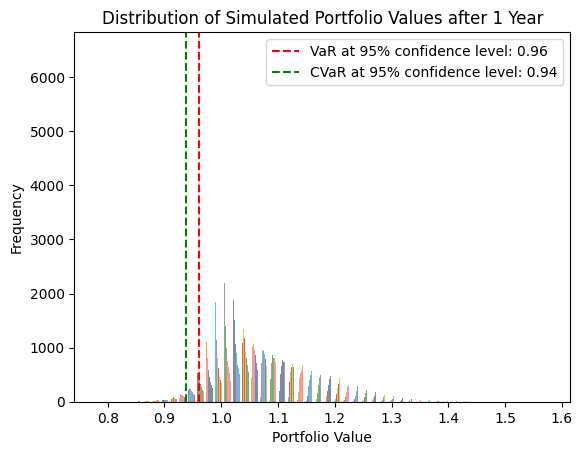

In [259]:
# XXXX - TO REMOVE
# Set the confidence level
confidence_level = 0.05

# download the data from yfinance
stock_symbol = "ICICIBANK.NS" 
drop_column_list =  ['High', 'Low', 'Open', 'Volume', 'Stock Splits', 'Dividends']

# Download the data from yahoo finance for calculating the performance metrics
ticker = yf.Ticker( stock_symbol )

ticker_df = ticker.history( period=setting.period, interval=setting.interval)
ticker_df.sort_index(ascending=True, inplace=True)
ticker_df.dropna(inplace = True)

# calculate the daily returns & drop the unnecessary columns
#ticker_df[ 'daily_returns'] = ta.others.DailyLogReturnIndicator( close=ticker_df['Close'] ).daily_log_return()
ticker_df[ 'daily_returns'] = ticker_df['Close'].pct_change()
ticker_df.drop( drop_column_list ,axis=1, inplace=True, errors='ignore')

calculate_emacrossover_returns( ticker_df, 7, 21, 0.05, 0.1)

ticker_df.dropna(inplace=True)

print ( calculate_risk_measures( ticker_df['ema_crossover_adjusted_returns'], confidence_level) )

simulated_results = monte_carlo_simulation(ticker_df['ema_crossover_adjusted_returns'], 10000, 252)

VaR_95 = np.percentile(simulated_results, 100 * confidence_level)
CVaR_95 = simulated_results[simulated_results <= VaR_95].mean()

# Print the results
print(f"Portfolio VaR at {confidence_level * 100}% confidence level: {VaR_95:.2f}")
print(f"Portfolio CVaR at {confidence_level * 100}% confidence level: {CVaR_95:.2f}")

# Plot the distribution of simulated portfolio values
plt.hist(simulated_results, bins=50, alpha=0.75)
plt.axvline(x=VaR_95, color='r', linestyle='--', label=f'VaR at 95% confidence level: {VaR_95:.2f}')
plt.axvline(x=CVaR_95, color='g', linestyle='--', label=f'CVaR at 95% confidence level: {CVaR_95:.2f}')
plt.title('Distribution of Simulated Portfolio Values after 1 Year')
plt.xlabel('Portfolio Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


[*********************100%%**********************]  2 of 2 completed


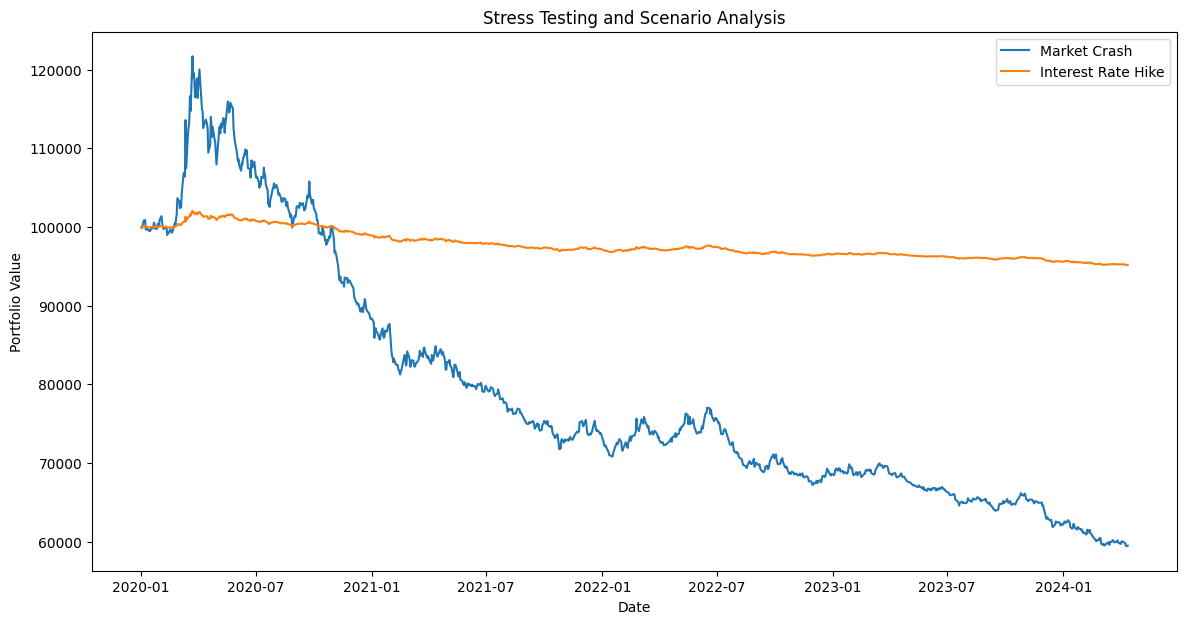

In [380]:
# Step 7: Comparative Analysis: Compare the performance of each strategy across different market conditions, including bull, bear, and volatile markets. 
#         Analyze how each strategy reacts to changing market dynamics.

# Define the tickers we are interested in
tickers = ["ICICIBANK.NS", "NV20BEES.NS" ]

# Fetch historical data from Yahoo Finance
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Define a portfolio, evenly distributed across our assets
portfolio_weights = np.array([1/len(tickers)] * len(tickers))

# Calculate portfolio returns
portfolio_returns = returns.dot(portfolio_weights)

# Stress scenarios (e.g., market crash, interest rate spike)
# Scenarios are defined as a dictionary with {name: returns_multiplier}
scenarios = {
    'Market Crash': -0.5,  # 50% reduction in asset prices
    'Interest Rate Hike': -0.05,  # 5% decrease in prices due to interest rates
}

# Function to apply stress scenario to portfolio returns
def apply_stress_scenario(returns, scenario, tickers):
    stressed_returns = returns.copy()
    if isinstance(scenario, dict):
        # Apply stress scenario to each asset
        for ticker, multiplier in scenario.items():
            print(scenario.items)
            stressed_returns[ticker] = stressed_returns[ticker] + np.abs(stressed_returns[ticker])*multiplier
    else:
        stressed_returns *= scenario
    return stressed_returns


# Apply each scenario and calculate stressed portfolio value
initial_investment = 100000  # Initial portfolio investment
stressed_portfolio_values = {}

for name, scenario in scenarios.items():
    stressed_returns = apply_stress_scenario(returns, scenario, tickers)
    stressed_portfolio_returns = stressed_returns.dot(portfolio_weights)
    stressed_portfolio_values[name] = (stressed_portfolio_returns + 1).cumprod() * initial_investment

# Convert the results to a DataFrame for easy viewing
stressed_portfolio_values_df = pd.DataFrame(stressed_portfolio_values)


# Visualizing the scenario analysis
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for scenario in stressed_portfolio_values:
    plt.plot(stressed_portfolio_values_df[scenario], label=scenario)
plt.title('Stress Testing and Scenario Analysis')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

In [ ]:
#Step 8 - Parameter Optimization: Simple Moving Average (SMA) Crossover Strategy

def optimize_sma_crossover_parameters(df, short_window_range, long_window_range, stop_loss_range, max_profit_range, initial_capital=10000):

    best_params = {}
    best_returns = float('-inf')

    # Generate all possible combinations of parameter values
    parameter_combinations = list(itertools.product(short_window_range, long_window_range, stop_loss_range, max_profit_range))

    for params in parameter_combinations:
        short_window = params[0]
        long_window = params[1]
        stop_loss = params[2]
        max_profit = params[3]

        # Calculate returns for current parameter values
        returns = calculate_smacrossover_returns(df, short_window, long_window, stop_loss, max_profit, initial_capital)['sma_crossover_captial_value'].iloc[-1]

        # Check if current returns are better than previous best returns
        if returns > best_returns:
            best_returns = returns
            best_params = {'short_window': short_window, 'long_window': long_window, 'stop_loss': stop_loss, 'max_profit': max_profit}

    return best_params, best_returns

# Define the parameter ranges to optimize
short_window_range = range(5, 21, 5)
long_window_range = range(20, 101, 10)
stop_loss_range = [0.05, 0.1, 0.15]
max_profit_range = [0.05, 0.1, 0.15]


# download the data from yfinance
stock_list =  [ "ICICIBANK.NS", "NV20BEES.NS"]
drop_column_list =  ['High', 'Low', 'Open', 'Volume', 'Stock Splits', 'Dividends']

for stock_symbol in stock_list:

    # Download the data from yahoo finance for calculating the performance metrics
    ticker = yf.Ticker( stock_symbol )

    ticker_df = ticker.history( period=setting.period, interval=setting.interval)
    ticker_df.sort_index(ascending=True, inplace=True)
    ticker_df.dropna(inplace = True)

    # calculate the daily returns & drop the unnecessary columns
    #ticker_df[ 'daily_returns'] = ta.others.DailyLogReturnIndicator( close=ticker_df['Close'] ).daily_log_return()
    ticker_df[ 'daily_returns'] = ticker_df['Close'].pct_change()
    ticker_df.drop( drop_column_list ,axis=1, inplace=True, errors='ignore')

    # Optimize the parameters
    best_params, best_returns = optimize_sma_crossover_parameters(ticker_df, short_window_range, long_window_range, stop_loss_range, max_profit_range)
    print ( f'Stock {stock_symbol} - Best Params: {best_params}, Best Returns, {best_returns}')


In [ ]:
#Step 8 - Parameter Optimization: Exponental Moving Average (EMA) Crossover Strategy

def optimize_ema_crossover_parameters(df, short_window_range, long_window_range, stop_loss_range, max_profit_range, initial_capital=10000):

    best_params = {}
    best_returns = float('-inf')

    # Generate all possible combinations of parameter values
    parameter_combinations = list(itertools.product(short_window_range, long_window_range, stop_loss_range, max_profit_range))

    for params in parameter_combinations:
        short_window = params[0]
        long_window = params[1]
        stop_loss = params[2]
        max_profit = params[3]

        # Calculate returns for current parameter values
        returns = calculate_emacrossover_returns(df, short_window, long_window, stop_loss, max_profit, initial_capital)['ema_crossover_captial_value'].iloc[-1]

        # Check if current returns are better than previous best returns
        if returns > best_returns:
            best_returns = returns
            best_params = {'short_window': short_window, 'long_window': long_window, 'stop_loss': stop_loss, 'max_profit': max_profit}

    return best_params, best_returns

# Define the parameter ranges to optimize
short_window_range = range(5, 21, 5)
long_window_range = range(20, 101, 10)
stop_loss_range = [0.05, 0.1, 0.15]
max_profit_range = [0.05, 0.1, 0.15]


# download the data from yfinance
stock_list =  [ "ICICIBANK.NS", "NV20BEES.NS"]
drop_column_list =  ['High', 'Low', 'Open', 'Volume', 'Stock Splits', 'Dividends']

for stock_symbol in stock_list:

    # Download the data from yahoo finance for calculating the performance metrics
    ticker = yf.Ticker( stock_symbol )

    ticker_df = ticker.history( period=setting.period, interval=setting.interval)
    ticker_df.sort_index(ascending=True, inplace=True)
    ticker_df.dropna(inplace = True)

    # calculate the daily returns & drop the unnecessary columns
    ticker_df[ 'daily_returns'] = ticker_df['Close'].pct_change()
    ticker_df.drop( drop_column_list ,axis=1, inplace=True, errors='ignore')

    # Optimize the parameters
    best_params, best_returns = optimize_ema_crossover_parameters(ticker_df, short_window_range, long_window_range, stop_loss_range, max_profit_range)
    print ( f'Stock {stock_symbol} - Best Params: {best_params}, Best Returns, {best_returns}')


In [ ]:
#Step 8 - Parameter Optimization: RSI Strategy

def optimize_rsi_parameters(df, rsi_period_range, rsi_upper_range, rsi_lower_range, stop_loss_range, max_profit_range, initial_capital=10000):

    best_params = {}
    best_returns = float('-inf')

    # Generate all possible combinations of parameter values
    parameter_combinations = list(itertools.product(rsi_period_range, rsi_upper_range, rsi_lower_range, stop_loss_range, max_profit_range))

    for params in parameter_combinations:
        rsi_period  = params[0]
        rsi_upper   = params[1]
        rsi_lower   = params[2]
        stop_loss   = params[3]
        max_profit  = params[4]

        # Calculate returns for current parameter values
        returns = calculate_rsi_returns(df, rsi_period, rsi_upper, rsi_lower, stop_loss, max_profit, initial_capital)['rsi_captial_value'].iloc[-1]

        # Check if current returns are better than previous best returns
        if returns > best_returns:
            best_returns = returns
            best_params = {'rsi_period': rsi_period, 'rsi_upper': rsi_upper, 'rsi_lower': rsi_lower, 'stop_loss': stop_loss, 'max_profit': max_profit}

    return best_params, best_returns

# Define the parameter ranges to optimize
rsi_period_range  = range(5, 21, 5)
rsi_upper_range   = range( 55, 75, 5)
rsi_lower_range   = range( 25, 45, 5)
stop_loss_range = [0.05, 0.1, 0.15]
max_profit_range = [0.05, 0.1, 0.15]

# download the data from yfinance
stock_list =  [ "ICICIBANK.NS", "NV20BEES.NS"]
drop_column_list =  ['High', 'Low', 'Open', 'Volume', 'Stock Splits', 'Dividends']

for stock_symbol in stock_list:

    # Download the data from yahoo finance for calculating the performance metrics
    ticker = yf.Ticker( stock_symbol )

    ticker_df = ticker.history( period=setting.period, interval=setting.interval)
    ticker_df.sort_index(ascending=True, inplace=True)
    ticker_df.dropna(inplace = True)

    # calculate the daily returns & drop the unnecessary columns
    #ticker_df[ 'daily_returns'] = ta.others.DailyLogReturnIndicator( close=ticker_df['Close'] ).daily_log_return()
    ticker_df[ 'daily_returns'] = ticker_df['Close'].pct_change()
    ticker_df.drop( drop_column_list ,axis=1, inplace=True, errors='ignore')

    # Optimize the parameters
    best_params, best_returns = optimize_rsi_parameters(ticker_df, rsi_period_range, rsi_upper_range, rsi_lower_range, stop_loss_range, max_profit_range)
    print ( f'Stock {stock_symbol} - Best Params: {best_params}, Best Returns, {best_returns}')


In [ ]:
#Step 8 - Parameter Optimization: DonChain Channel Strategy

def optimize_dc_parameters(df, window_range, stop_loss_range, max_profit_range, initial_capital=10000):

    best_params = {}
    best_returns = float('-inf')

    # Generate all possible combinations of parameter values
    parameter_combinations = list(itertools.product(window_range, stop_loss_range, max_profit_range))

    for params in parameter_combinations:
        window      = params[0]
        stop_loss   = params[1]
        max_profit  = params[2]

        # Calculate returns for current parameter values
        #returns = calculate_dd_returns(df, rsi_period, rsi_upper, rsi_lower, stop_loss, max_profit, initial_capital)['rsi_captial_value'].iloc[-1]
        returns = calculate_dc_returns(df, window, stop_loss, max_profit )['dc_captial_value'].iloc[-1]   

        # Check if current returns are better than previous best returns
        if returns > best_returns:
            best_returns = returns
            best_params = { 'window': window, 'stop_loss': stop_loss, 'max_profit': max_profit}

    return best_params, best_returns

# Define the parameter ranges to optimize
window_range  = range(5, 21, 1)
stop_loss_range = [0.05, 0.1, 0.15]
max_profit_range = [0.05, 0.1, 0.15]

# download the data from yfinance
stock_list =  [ "ICICIBANK.NS", "NV20BEES.NS"]
drop_column_list =  ['High', 'Low', 'Open', 'Volume', 'Stock Splits', 'Dividends']

for stock_symbol in stock_list:

    # Download the data from yahoo finance for calculating the performance metrics
    ticker = yf.Ticker( stock_symbol )

    ticker_df = ticker.history( period=setting.period, interval=setting.interval)
    ticker_df.sort_index(ascending=True, inplace=True)
    ticker_df.dropna(inplace = True)

    # calculate the daily returns & drop the unnecessary columns
    #ticker_df[ 'daily_returns'] = ta.others.DailyLogReturnIndicator( close=ticker_df['Close'] ).daily_log_return()
    ticker_df[ 'daily_returns'] = ticker_df['Close'].pct_change()
    ticker_df.drop( drop_column_list ,axis=1, inplace=True, errors='ignore')

    # Optimize the parameters
    best_params, best_returns = optimize_dc_parameters(ticker_df, window_range, stop_loss_range, max_profit_range)
    print ( f'Stock {stock_symbol} - Best Params: {best_params}, Best Returns, {best_returns}')


In [407]:
#Step 8 - Parameter Optimization: Bollinger Band Strategy

def optimize_bb_parameters(df, window_range, window_dev_range, stop_loss_range, max_profit_range ):

    best_params = {}
    best_returns = float('-inf')

    # Generate all possible combinations of parameter values
    parameter_combinations = list(itertools.product(window_range, window_dev_range, stop_loss_range, max_profit_range))

    for params in parameter_combinations:
        window      = params[0]
        window_dev  = params[1]
        stop_loss   = params[2]
        max_profit  = params[3]

        # Calculate returns for current parameter values
        returns = calculate_bb_returns(df, window, window_dev, stop_loss, max_profit )['bb_captial_value'].iloc[-1]   

        # Check if current returns are better than previous best returns
        if returns > best_returns:
            best_returns = returns
            best_params = { 'window': window, 'window_dev': window_dev, 'stop_loss': stop_loss, 'max_profit': max_profit}

    return best_params, best_returns

# Define the parameter ranges to optimize
window_range  = range(5, 21, 1)
window_dev_range = [ 1, 1.5, 2, 2.5]
stop_loss_range = [0.05, 0.1 ]
max_profit_range = [0.05, 0.1, 0.15]

# download the data from yfinance
stock_list =  [ "ICICIBANK.NS", "NV20BEES.NS"]
drop_column_list =  ['High', 'Low', 'Open', 'Volume', 'Stock Splits', 'Dividends']

for stock_symbol in stock_list:

    # Download the data from yahoo finance for calculating the performance metrics
    ticker = yf.Ticker( stock_symbol )

    ticker_df = ticker.history( period=setting.period, interval=setting.interval)
    ticker_df.sort_index(ascending=True, inplace=True)
    ticker_df.dropna(inplace = True)

    # calculate the daily returns & drop the unnecessary columns
    #ticker_df[ 'daily_returns'] = ta.others.DailyLogReturnIndicator( close=ticker_df['Close'] ).daily_log_return()
    ticker_df[ 'daily_returns'] = ticker_df['Close'].pct_change()
    #ticker_df.drop( drop_column_list ,axis=1, inplace=True, errors='ignore')

    # Optimize the parameters
    best_params, best_returns = optimize_bb_parameters(ticker_df, window_range, window_dev_range, stop_loss_range, max_profit_range)
    print ( f'Stock {stock_symbol} - Best Params: {best_params}, Best Returns, {best_returns}')


TypeError: 'NoneType' object is not subscriptable

[*********************100%%**********************]  2 of 2 completed


Ticker      HDFCBANK.NS  ICICIBANK.NS
Date                                 
2020-01-02     0.006354      0.007147
2020-01-03    -0.014363     -0.003242
2020-01-06    -0.021879     -0.024706
2020-01-07     0.015711     -0.005341
2020-01-08    -0.002621      0.005816
Portfolio VaR (percentile method) at 5.0% confidence level: -2.69%
Portfolio VaR (parametric method) at 5.0% confidence level: -2.97%


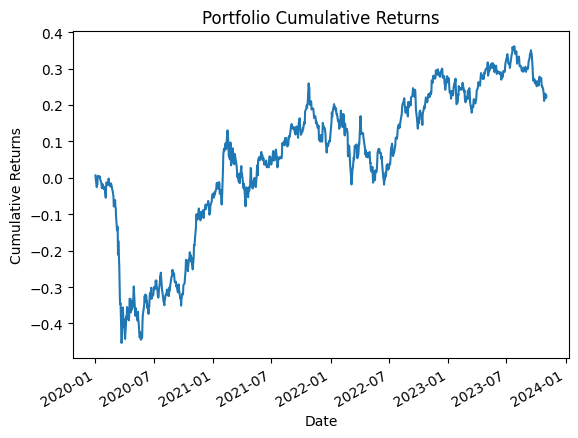

In [210]:
 ## TO-REMOVE
portfolio = {

    'ICICIBANK.NS': 0.5,  
    'HDFCBANK.NS': 0.5   
}

start_date = '2020-01-01'
end_date = '2023-11-03'

ticker_df = yf.download(list(portfolio.keys()), start=start_date, end=end_date)['Adj Close']
ticker_df.sort_index(ascending=True, inplace=True)
ticker_df.dropna(inplace = True)

returns = np.log( 1 + ticker_df.pct_change() ).dropna()

print( returns.head() )

portfolio_returns = returns.dot( np.array( list( portfolio.values() ) ) )

mean_returns = portfolio_returns.mean()
sigma_returns = portfolio_returns.std()

# Set the confidence level
confidence_level = 0.05

# Calculate VaR using the percentile method
VaR = np.percentile(portfolio_returns, confidence_level * 100)

# Calculate VaR using the parametric method (assuming normal distribution)
VaR_parametric = norm.ppf(confidence_level, mean_returns, sigma_returns)

# Print the results
print(f"Portfolio VaR (percentile method) at {confidence_level * 100}% confidence level: {VaR * 100:.2f}%")
print(f"Portfolio VaR (parametric method) at {confidence_level * 100}% confidence level: {VaR_parametric * 100:.2f}%")

import matplotlib.pyplot as plt

cumulative_returns = (1 + portfolio_returns).cumprod() - 1
cumulative_returns.plot()
plt.title('Portfolio Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()